<a href="https://colab.research.google.com/github/EddyGiusepe/NLP_with_Disaster_Tweets_Transfer_Learning/blob/main/Baseline_NLP_with_Disaster_Tweest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2 align="center">Natural Language Processing with Disaster Tweets</h2>

Data Scientist: Dr.Eddy Giusepe Chirinos Isidro

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Ver este link --> https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

#!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torchtext
import os
from pathlib import Path


import torchtext
from torchtext.legacy.data import Field, LabelField
from torchtext.legacy import data

In [4]:
PATH = Path('/content/drive/MyDrive/5_Scripts_in_Python_Eddy/3_SENSIO_ML_DL/Kaggle_NLP_with_Disaster_Tweets/data_Tweets')
os.listdir(PATH)

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'test_clean.csv',
 'train_clean.csv']

In [5]:
# Vamos a usar torchtext
TEXT = Field(tokenize="spacy")
LABEL = data.LabelField(dtype=torch.long)

dataset = data.TabularDataset(path = PATH/'train_clean.csv',format = 'CSV', fields = [('text', TEXT), ('target', LABEL)], skip_header = True)

len(dataset)

7613

In [6]:
ix = 0
print(vars(dataset.examples[ix]))

{'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'target': '1'}


In [7]:
# Dividimos nossos Dados

train_dataset, valid_dataset = dataset.split(
    split_ratio=0.75,
    stratified=True, # Isto é para balancear os Dados (balança ambas classes)
    strata_field='target' 
)

print("Treinamos com:",len(train_dataset), "e Validamos com:",len(valid_dataset))


Treinamos com: 5709 e Validamos com: 1904


In [8]:
MAX_VOCAB_SIZE = 10000 # Máximo de palavras que teremos no Teewst

TEXT.build_vocab(train_dataset, max_size=MAX_VOCAB_SIZE) # Vai contar as palavras e assinar um número, frequência, etc 
LABEL.build_vocab(train_dataset)


In [9]:
# vocab-->Vocabulário.
# 10002 --> Se adicionaram mais dois TOKENS extras (unk e pad)
len(TEXT.vocab), len(LABEL.vocab)

(10002, 2)

In [10]:
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '#', '?', '.', 'the', ':', 'a', 'to', 'in']

In [11]:
# As 10 palavras mais frequentes

TEXT.vocab.freqs.most_common(10)

[('#', 2513),
 ('?', 2371),
 ('.', 2189),
 ('the', 1952),
 (':', 1440),
 ('a', 1402),
 ('to', 1372),
 ('in', 1335),
 ('of', 1332),
 ('I', 1180)]

In [12]:

device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = {
    'train': data.BucketIterator(train_dataset, batch_size=64, shuffle=True, device=device),
    'val': data.BucketIterator(valid_dataset, batch_size=100, device=device)
}


In [13]:
# Vamos a entrenar uma RNN


class RNN(torch.nn.Module):
  def __init__(self, input_dim, embedding_dim=128, hidden_size=128, num_layers=2, n_outputs=2): # n_outputs=2 ou zero ou um (duas classes)
    super().__init__()
    self.embedding = torch.nn.Embedding(input_dim, embedding_dim) # Melhor que fazer one-hot-encoded
    self.rnn = torch.nn.RNN(
        input_size=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers)
    self.fc = torch.nn.Linear(hidden_size, n_outputs)

  def forward(self, text):
    embedded = self.embedding(text)
    output, _ = self.rnn(embedded)
    # [l, bs, h]
    return self.fc(output[-1,:,:].squeeze(0))    





In [14]:
model = RNN(input_dim = len(TEXT.vocab))

# Fazemos uma simulação para verificar o funcionamento de nossa REDE
output = model(torch.randint(0, len(TEXT.vocab), (100, 64)))
output.shape

torch.Size([64, 2])

In [15]:
import sklearn.metrics as m

def fit(model, dataloader, epochs=10, lr=1e-3):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0.
    for e in range(1, epochs+1):
        model.train()
        l, f1s = [], []
        for batch in dataloader['train']:
            optimizer.zero_grad()
            y_pred = model(batch.text)
            loss = criterion(y_pred, batch.target)
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            y_pred = torch.argmax(y_pred, axis=1)
            f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['loss'].append(np.mean(l))
        hist['f1'].append(np.mean(f1s))
        model.eval()
        l, acc, f1s = [], [], []
        with torch.no_grad():
            for batch in dataloader['val']:
                y_pred = model(batch.text)
                loss = criterion(y_pred, batch.target)
                l.append(loss.item())          
                y_pred = torch.argmax(y_pred, axis=1)
                f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['val_loss'].append(np.mean(l))
        hist['val_f1'].append(np.mean(f1s))
        if hist["val_f1"][-1] > best_f1:
            best_f1 = hist["val_f1"][-1]
            torch.save(model.state_dict(), 'ckpt.pt')
        print(f'Epoch {e}/{epochs} loss {hist["loss"][-1]:.5f} f1 {hist["f1"][-1]:.5f} val_loss {hist["val_loss"][-1]:.5f} val_f1 {hist["val_f1"][-1]:.5f}')
    model.load_state_dict(torch.load('ckpt.pt'))
    return hist

In [16]:
model = RNN(input_dim=len(TEXT.vocab))

hist = fit(model, dataloader)

Epoch 1/10 loss 0.69531 f1 0.11831 val_loss 0.68274 val_f1 0.04020
Epoch 2/10 loss 0.68485 f1 0.01563 val_loss 0.68624 val_f1 0.00954
Epoch 3/10 loss 0.68429 f1 0.02606 val_loss 0.68389 val_f1 0.04607
Epoch 4/10 loss 0.68350 f1 0.03329 val_loss 0.68260 val_f1 0.00842
Epoch 5/10 loss 0.68319 f1 0.03951 val_loss 0.68196 val_f1 0.00444
Epoch 6/10 loss 0.68463 f1 0.05767 val_loss 0.68514 val_f1 0.00371
Epoch 7/10 loss 0.68415 f1 0.02621 val_loss 0.68982 val_f1 0.01503
Epoch 8/10 loss 0.68234 f1 0.01294 val_loss 0.68866 val_f1 0.00208
Epoch 9/10 loss 0.68097 f1 0.02210 val_loss 0.69391 val_f1 0.00233
Epoch 10/10 loss 0.68055 f1 0.01621 val_loss 0.67995 val_f1 0.00000


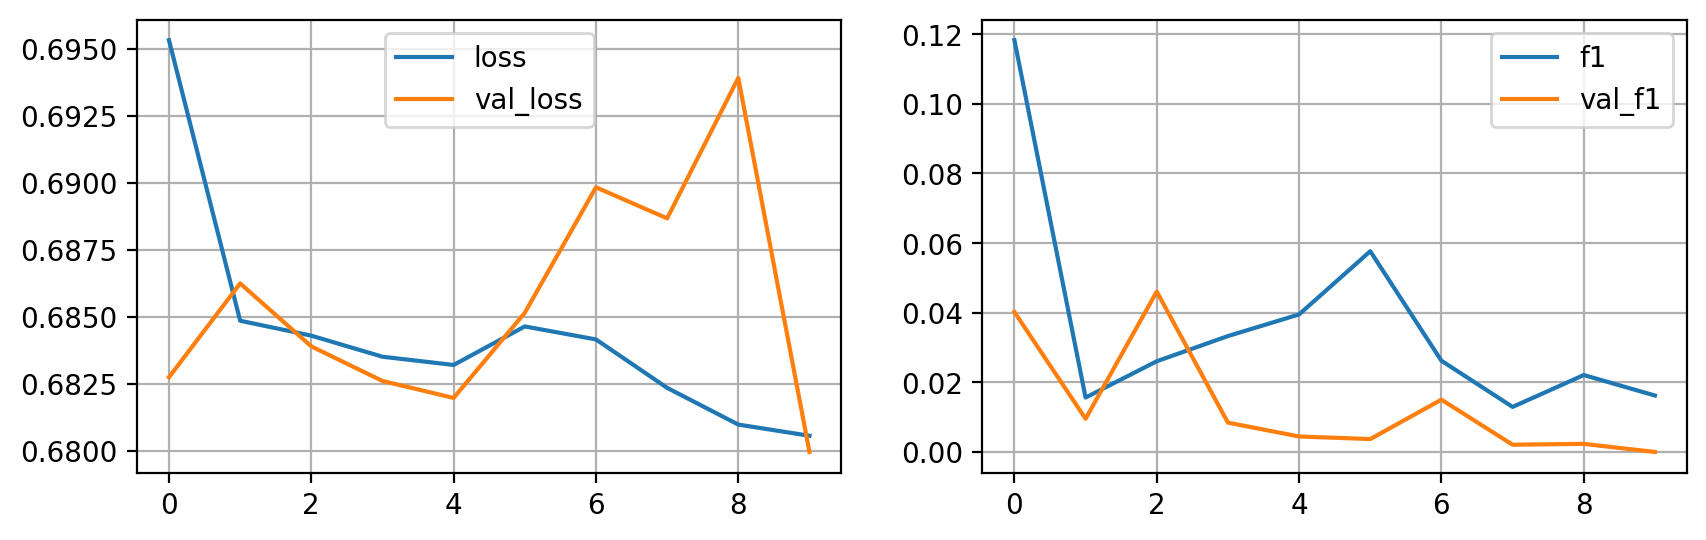

In [17]:
def plot(hist):
    fig = plt.figure(dpi=200,figsize=(10,3))
    ax = plt.subplot(121)
    hist = pd.DataFrame(hist)
    hist[['loss', 'val_loss']].plot(ax=ax, grid=True)
    ax = plt.subplot(122)
    hist[['f1', 'val_f1']].plot(ax=ax, grid=True)
    plt.show()
    
plot(hist)

## Fazendo uma LSTM

In [18]:
class LSTM(RNN):
    def __init__(self, input_dim, embedding_dim=128, hidden_size=128, num_layers=2, n_outputs=2, bidirectional=False, dropout=0):
        super().__init__(input_dim, embedding_dim, hidden_size, num_layers, n_outputs)
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout
        )
        if bidirectional:
            self.fc = torch.nn.Linear(2*hidden_size, n_outputs)


# Estas REDES RNN-LSTM funciona melhor, para comprimentos de texto maior     

Epoch 1/10 loss 0.68392 f1 0.01259 val_loss 0.68669 val_f1 0.00238
Epoch 2/10 loss 0.63683 f1 0.37681 val_loss 0.62081 val_f1 0.53273
Epoch 3/10 loss 0.51710 f1 0.69523 val_loss 0.56501 val_f1 0.61456
Epoch 4/10 loss 0.41998 f1 0.78343 val_loss 0.55821 val_f1 0.64986
Epoch 5/10 loss 0.35980 f1 0.82917 val_loss 0.61447 val_f1 0.62531
Epoch 6/10 loss 0.28753 f1 0.87439 val_loss 0.66766 val_f1 0.63021
Epoch 7/10 loss 0.24115 f1 0.90035 val_loss 0.63654 val_f1 0.66895
Epoch 8/10 loss 0.21091 f1 0.92008 val_loss 0.68681 val_f1 0.67683
Epoch 9/10 loss 0.18622 f1 0.93157 val_loss 0.71911 val_f1 0.70162
Epoch 10/10 loss 0.15803 f1 0.94134 val_loss 0.92690 val_f1 0.66786


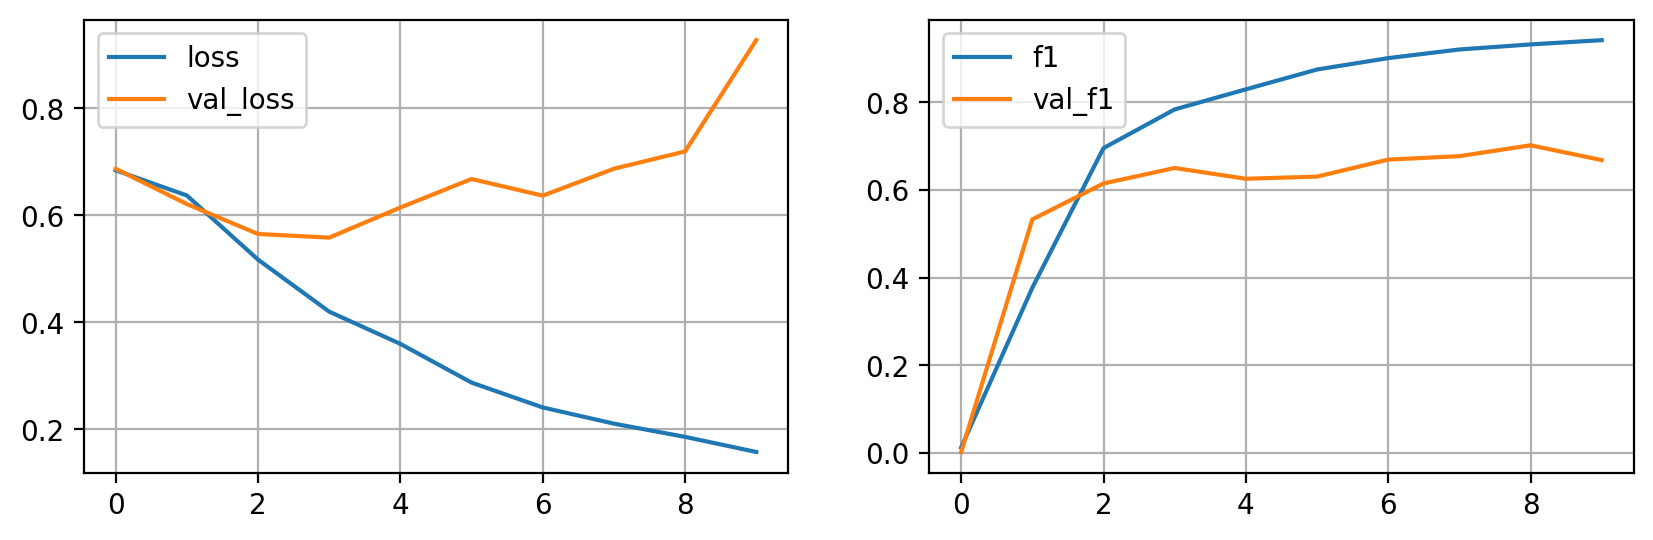

In [19]:
model = LSTM(input_dim=len(TEXT.vocab), bidirectional=False)
hist = fit(model, dataloader)

plot(hist)

# Vamos fazer aqui a SUBMISSION

In [20]:
test_dataset = data.TabularDataset(
    path = PATH/'test_clean.csv',
    format = 'CSV',
    fields = [('text', TEXT)], # Esse objeto TEXT já tem os tokens e vocabulário. 
    skip_header = True
)

len(test_dataset)

3263

In [23]:

ix = 1

print(vars(test_dataset.examples[ix]))

{'text': ['Heard', 'about', '#', 'earthquake', 'is', 'different', 'cities', ',', 'stay', 'safe', 'everyone', '.']}


In [24]:
# Importante:
# shuffle=False. Tem que ser False. Se você colocar NONE ele misturará os Dados, e isso não queremos
# Porque mantemos a ordem para depois comparar

test_dataloader = data.BucketIterator(test_dataset, batch_size=64, shuffle=False, device=device)

In [25]:
def predict():
    model.eval()
    preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch in test_dataloader:
            y_pred = model(batch.text)        
            y_pred = torch.argmax(y_pred, axis=1)
            preds = torch.cat([preds, y_pred])
    return preds

In [29]:
preds = predict()

preds

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [30]:
preds.shape

torch.Size([3263])

In [28]:
submission = pd.read_csv(PATH  / 'sample_submission.csv')

submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [31]:
# A prediçoes do nosso Modelo

submission.target = preds.cpu().long() # .long() --> para que seja um número inteiro

submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


In [33]:
submission.to_csv(PATH/'submission.csv', index=False)